In [2]:
import pandas as pd 
import numpy as np
import joblib
import time
from sklearn.metrics import accuracy_score
import sklearn.metrics
from sklearn.ensemble import ExtraTreesClassifier
from xgboost import XGBClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from catboost import CatBoostClassifier

## Load data

In [3]:
X_train = pd.read_csv('./DS/FDM_DS_X_train.csv')
y_train = pd.read_csv('./DS/FDM_DS_y_train.csv')
X_test = pd.read_csv('./DS/X_test_SFS.csv')
y_test = pd.read_csv('./DS/y_test_SFS.csv')

def calculate_macro_tpr_fpr(voting_cm):
    num_classes = voting_cm.shape[0]
    tpr_list = []
    fpr_list = []

    for i in range(num_classes):
        TP = voting_cm[i, i]
        FN = np.sum(voting_cm[i, :]) - TP
        FP = np.sum(voting_cm[:, i]) - TP
        TN = np.sum(voting_cm) - (TP + FN + FP)

        TPR = TP / (TP + FN) if (TP + FN) > 0 else 0
        FPR = FP / (FP + TN) if (FP + TN) > 0 else 0

        tpr_list.append(TPR)
        fpr_list.append(FPR)

    macro_tpr = np.mean(tpr_list)
    macro_fpr = np.mean(fpr_list)

    return macro_tpr, macro_fpr

## XGBoost

In [19]:
xgb_params = {
    'device': 'cuda',
    'max_depth': 128,
    # 'n_estimators': 3000,
    'objective': 'binary:logistic',
    'booster': 'gbtree',
    'learning_rate': 0.1,
    'eval_metric': 'auc'
}


print("XGBClassifier Starting")
xgb_model = XGBClassifier(**xgb_params)
xgb_model.fit(X_train,y_train)
# joblib.dump(xgb_model, './models/FDM_XGB.pkl')
# xgb_model = joblib.load('./models/FDM_XGB.pkl')
xgb_start_time = time.time()
xgb_prediction = xgb_model.predict(X_test)
xgb_end_time = time.time()
xgb_time = xgb_end_time - xgb_start_time
print("XGBClassifier Finished")

xgb_acc = sklearn.metrics.accuracy_score(xgb_prediction, y_test)
xgb_precision = sklearn.metrics.precision_score(xgb_prediction, y_test, average='macro')
xgb_f1 = sklearn.metrics.f1_score(xgb_prediction, y_test, average='macro')
xgb_recall = sklearn.metrics.recall_score(xgb_prediction, y_test, average='macro')
xgb_cm = sklearn.metrics.confusion_matrix(xgb_prediction, y_test)
xgb_probs = xgb_model.predict_proba(X_test)
xgb_auc = sklearn.metrics.roc_auc_score(y_test, xgb_probs, average='macro', multi_class='ovr')
xgb_tpr, xgb_fpr = calculate_macro_tpr_fpr(xgb_cm)
print("XGBoost report:")
print("XGBoost Time:", xgb_time)
print("XGBoost Accuracy:", xgb_acc)
print("XGBoost Precision:", xgb_precision)
print("XGBoost F1:", xgb_f1)
print("XGBoost Recall:", xgb_recall)
print("XGBoost ROC AUC:", xgb_auc)
print("XGBoost CM:\n", xgb_cm)
print(f'XGBoost Macro-average TPR: {xgb_tpr}')
print(f'XGBoost Macro-average FPR: {xgb_fpr}')

XGBClassifier Starting
XGBClassifier Finished
XGBoost report:
XGBoost Time: 0.0500340461730957
XGBoost Accuracy: 0.8427021696252466
XGBoost Precision: 0.8427021696252467
XGBoost F1: 0.8374020190528686
XGBoost Recall: 0.837486799560068
XGBoost ROC AUC: 0.986794081354846
XGBoost CM:
 [[169   0   0   0   0   0   0   3   0   0   0   0]
 [  0 169   0   0   0   0   0   1   0   0   0   0]
 [  0   0 169   0   0   0   0  40   0  10   0   0]
 [  0   0   0 169   0   0   0   0   0   0   0   0]
 [  0   0   0   0 169   1   0   1   0   0   0   0]
 [  0   0   0   0   0 168   0   0   0   0   0   0]
 [  0   0   0   0   0   0 169   1   0   0   0   0]
 [  0   0   0   0   0   0   0  66  44   7   0   0]
 [  0   0   0   0   0   0   0  36 125   0   0   0]
 [  0   0   0   0   0   0   0   7   0  87  89   0]
 [  0   0   0   0   0   0   0  14   0  65  80   0]
 [  0   0   0   0   0   0   0   0   0   0   0 169]]
XGBoost Macro-average TPR: 0.837486799560068
XGBoost Macro-average FPR: 0.014172235756772176


## ExtraTree

In [10]:
et_params = {
    "n_estimators": 32,
    "max_leaf_nodes": 15000,
    "n_jobs": -1,
    "random_state": 0,
    "bootstrap": True,
    "criterion": "entropy"
}

print("ExtraTreesClassifier Starting")
et_model = ExtraTreesClassifier(**et_params)
et_model.fit(X=X_train, y=y_train)
# joblib.dump(et_model, './models/FDM_ET.pkl')
# et_model = joblib.load('./models/FDM_ET.pkl')
et_start_time = time.time()
et_prediction = et_model.predict(X_test)
et_end_time = time.time()
et_time = et_end_time - et_start_time
print("ExtraTreesClassifier Finished")

et_acc = sklearn.metrics.accuracy_score(et_prediction, y_test)
et_precision = sklearn.metrics.precision_score(et_prediction, y_test, average='macro')
et_f1 = sklearn.metrics.f1_score(et_prediction, y_test, average='macro')
et_recall = sklearn.metrics.recall_score(et_prediction, y_test, average='macro')
et_cm = sklearn.metrics.confusion_matrix(et_prediction, y_test)
et_probs = et_model.predict_proba(X_test)
et_auc = sklearn.metrics.roc_auc_score(y_test, et_probs, average='macro', multi_class='ovr')
et_tpr, et_fpr = calculate_macro_tpr_fpr(et_cm)
print("ExtraTrees report:")
print("ExtraTrees Time:", et_end_time - et_start_time)
print("ExtraTrees Accuracy:", et_acc)
print("ExtraTrees Precision:", et_precision)
print("ExtraTrees F1:", et_f1)
print("ExtraTrees Recall:", et_recall)
print("ExtraTrees ROC AUC:", et_auc)
print("ExtraTrees CM:\n", et_cm)
print(f'ExtraTrees Macro-average TPR: {et_tpr}')
print(f'ExtraTrees Macro-average FPR: {et_fpr}')

ExtraTreesClassifier Starting
ExtraTreesClassifier Finished
ExtraTrees report:
ExtraTrees Time: 0.03663492202758789
ExtraTrees Accuracy: 0.8589743589743589
ExtraTrees Precision: 0.858974358974359
ExtraTrees F1: 0.854332793622381
ExtraTrees Recall: 0.8571633965861861
ExtraTrees ROC AUC: 0.9846702379701925
ExtraTrees CM:
 [[169   0   0   0   0   0   0   0   0   0   0   0]
 [  0 169   0   0   0   0   0   1   0   0   0   0]
 [  0   0 169   0   0   0   0  27   0  11   0   0]
 [  0   0   0 169   0   0   0   0   0   0   0   0]
 [  0   0   0   0 169   1   0   0   0   0   0   0]
 [  0   0   0   0   0 167   0   0   0   0   0   0]
 [  0   0   0   0   0   1 169   0   0   0   0   0]
 [  0   0   0   0   0   0   0  76  32   4   1   0]
 [  0   0   0   0   0   0   0  38 137   0   0   0]
 [  0   0   0   0   0   0   0  10   0 107  96   0]
 [  0   0   0   0   0   0   0  17   0  47  72   0]
 [  0   0   0   0   0   0   0   0   0   0   0 169]]
ExtraTrees Macro-average TPR: 0.8571633965861861
ExtraTrees Macro

## RandomForest

In [13]:
rf_params = {
    "n_estimators": 21,
    "max_leaf_nodes": 15000,
    "n_jobs": -1,
    "random_state": 0,
    "bootstrap": True,
    "criterion": "entropy"
}

print("RandomForestClassifier Starting")
rf_model = RandomForestClassifier(**rf_params)
rf_model.fit(X=X_train, y=y_train)
# joblib.dump(rf_model, './models/FDM_RF.pkl')
# rf_model = joblib.load('./models/FDM_RF.pkl')
rf_start_time = time.time()
rf_prediction = rf_model.predict(X_test)
rf_end_time = time.time()
rf_time = rf_end_time - rf_start_time
print("RandomForestClassifier Finished")

rf_acc = sklearn.metrics.accuracy_score(rf_prediction, y_test)
rf_precision = sklearn.metrics.precision_score(rf_prediction, y_test, average='macro')
rf_f1 = sklearn.metrics.f1_score(rf_prediction, y_test, average='macro')
rf_recall = sklearn.metrics.recall_score(rf_prediction, y_test, average='macro')
rf_cm = sklearn.metrics.confusion_matrix(rf_prediction, y_test)
rf_probs = rf_model.predict_proba(X_test)
rf_auc = sklearn.metrics.roc_auc_score(y_test, rf_probs, average='macro', multi_class='ovr')
rf_tpr, rf_fpr = calculate_macro_tpr_fpr(rf_cm)
print("RandomForest report:")
print("RandomForest Time:", rf_end_time - rf_start_time)
print("RandomForest Accuracy:", rf_acc)
print("RandomForest Precision:", rf_precision)
print("RandomForest F1:", rf_f1)
print("RandomForest Recall:", rf_recall)
print("RandomForest ROC AUC:", rf_auc)
print("RandomForest CM:\n", rf_cm)
print(f'RandomForest Macro-average TPR: {rf_tpr}')
print(f'RandomForest Macro-average FPR: {rf_fpr}')

RandomForestClassifier Starting
RandomForestClassifier Finished
RandomForest report:
RandomForest Time: 0.03446459770202637
RandomForest Accuracy: 0.8589743589743589
RandomForest Precision: 0.8589743589743589
RandomForest F1: 0.8552826634287142
RandomForest Recall: 0.8569239300827869
RandomForest ROC AUC: 0.9857108071718906
RandomForest CM:
 [[168   0   0   0   0   0   0   0   0   0   0   0]
 [  0 169   0   0   0   0   0   1   0   0   0   0]
 [  0   0 169   0   0   0   0  33   0  11   0   0]
 [  0   0   0 168   0   0   0   0   0   0   0   0]
 [  0   0   0   0 168   0   0   1   0   0   0   0]
 [  0   0   0   0   0 169   0   0   0   0   0   0]
 [  0   0   0   1   1   0 169   1   0   0   0   0]
 [  0   0   0   0   0   0   0  86  36   6   0   0]
 [  0   0   0   0   0   0   0  32 133   0   0   0]
 [  0   0   0   0   0   0   0   6   0  99  94   0]
 [  1   0   0   0   0   0   0   9   0  53  75   0]
 [  0   0   0   0   0   0   0   0   0   0   0 169]]
RandomForest Macro-average TPR: 0.856923930

## Voting

In [4]:
xgb_model = XGBClassifier()
xgb_model = joblib.load('./models/FDM_XGB.pkl')
et_model = ExtraTreesClassifier()
et_model = joblib.load('./models/FDM_ET.pkl')
rf_model = RandomForestClassifier()
rf_model = joblib.load('./models/FDM_RF.pkl')

xgb_preds = xgb_model.predict_proba(X_test)
et_preds = et_model.predict_proba(X_test)
rf_preds = rf_model.predict_proba(X_test)

xgb_prediction = xgb_model.predict(X_test)
et_prediction = et_model.predict(X_test)
rf_prediction = rf_model.predict(X_test)

xgb_acc = sklearn.metrics.accuracy_score(xgb_prediction, y_test)
et_acc = sklearn.metrics.accuracy_score(et_prediction, y_test)
rf_acc = sklearn.metrics.accuracy_score(rf_prediction, y_test)

print("XGBoost Accuracy:", xgb_acc)
print("ExtraTree Accuracy:", et_acc)
print("RandomForest Accuracy:", rf_acc)

/home/vvhoang/miniconda3/envs/test_env/lib/python3.8/site-packages/xgboost/core.py:160: UserWarning: [20:52:15] WARNING: /workspace/src/common/error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

  warnings.warn(smsg, UserWarning)


XGBoost Accuracy: 0.8427021696252466
ExtraTree Accuracy: 0.8589743589743589
RandomForest Accuracy: 0.8589743589743589


In [5]:
avgs = (
    0.005 * xgb_preds
    + 0.97 * et_preds
    + 0.025 * rf_preds
)


voting_prediction = avgs.argmax(axis=1)
voting_acc = sklearn.metrics.accuracy_score(voting_prediction, y_test)
voting_precision = sklearn.metrics.precision_score(voting_prediction, y_test, average='macro')
voting_f1 = sklearn.metrics.f1_score(voting_prediction, y_test, average='macro')
voting_recall = sklearn.metrics.recall_score(voting_prediction, y_test, average='macro')
voting_cm = sklearn.metrics.confusion_matrix(voting_prediction, y_test)
voting_auc = sklearn.metrics.roc_auc_score(y_test, avgs, average='macro', multi_class='ovr')
macro_tpr, macro_fpr = calculate_macro_tpr_fpr(voting_cm)
print("Voting report:")
print("Voting Accuracy:", voting_acc)
print("Voting Precision:", voting_precision)
print("Voting F1:", voting_f1)
print("Voting Recall:", voting_recall)
print("Voting ROC AUC:", voting_auc)
print("Voting CM:\n", voting_cm)
print(f'Voting Macro-average TPR: {macro_tpr}')
print(f'Voting Macro-average FPR: {macro_fpr}')

Voting report:
Voting Accuracy: 0.8599605522682445
Voting Precision: 0.8599605522682445
Voting F1: 0.8555825423428373
Voting Recall: 0.8583746466877162
Voting ROC AUC: 0.9882502946908955
Voting CM:
 [[169   0   0   0   0   0   0   0   0   0   0   0]
 [  0 169   0   0   0   0   0   1   0   0   0   0]
 [  0   0 169   0   0   0   0  26   0  10   0   0]
 [  0   0   0 169   0   0   0   0   0   0   0   0]
 [  0   0   0   0 169   1   0   0   0   0   0   0]
 [  0   0   0   0   0 167   0   0   0   0   0   0]
 [  0   0   0   0   0   1 169   0   0   0   0   0]
 [  0   0   0   0   0   0   0  76  30   5   0   0]
 [  0   0   0   0   0   0   0  39 139   0   0   0]
 [  0   0   0   0   0   0   0  10   0 104  94   0]
 [  0   0   0   0   0   0   0  17   0  50  75   0]
 [  0   0   0   0   0   0   0   0   0   0   0 169]]
Voting Macro-average TPR: 0.8583746466877162
Voting Macro-average FPR: 0.01261328568193344


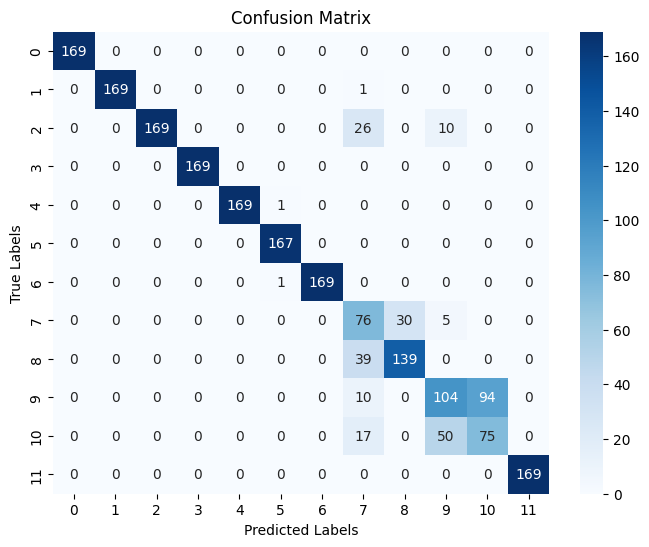

In [6]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
sns.heatmap(voting_cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()